In [635]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations
from collections import Counter
import random

%matplotlib inline

In [616]:
df_students = pd.read_csv('stud_math.xls')
df_students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [617]:
# renaming a column with ,
df_students.rename(columns={'studytime, granular':'studytime_granular'}, inplace=True)

In [618]:
df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [619]:
# rows with missing scores don't really make much sense
df_students.dropna(subset=['score'], inplace=True)

# Visual inspection of data

There are 395 rows and 30 columns in a dataset. From a first glance most columns look rather complete (not too many missing values) - this, however, will be further explored later.

There are 17 columns of type "object", one column of type "int64" and 12 columns of type "float64" (one of them is our target variable "score"). However, it seems that 9 float variables (Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, health) are categorical by nature. Moreover, some of them (traveltime, studytime, failures, famrel, freetime, goout, health) are ordinal.

In [620]:
# define numeric columns manually
cols_numeric = ['age', 'absences', 'score']

# remaining columns are considered categorical
cols_categorical = list(
    filter(lambda x: x not in cols_numeric, list(df_students.columns)))

# keeping ordinal columns (a subset of categorical) in a separate list
# for convenience (just in case)
cols_ordinal = ['traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'health']

print(
    f'Numeric columns are: {cols_numeric}. \n\nCategorical columns are: {cols_categorical}.')

Numeric columns are: ['age', 'absences', 'score']. 

Categorical columns are: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime_granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health'].


# Definitions of helper functions are in a cell below

In [772]:
def describe_dataframe(df, cols_numeric):
    '''
    Creates a dataframe with useful descriptors
    for all the columns in df (passed as argument).

    Please note that cols_numeric (a list of columns
    that are considered numeric) is mandatory.
    '''

    row_cnt = df.shape[0]

    # these lists will be populated below and
    # zipped into a dataframe in the end
    cols = []
    col_type = []
    cnt_filled = []
    unique = []
    missing = []
    missing_percent = []
    freq_dict = []

    for c in df.columns:
        cols.append(c)
        if c in cols_numeric:
            col_type.append('numeric')
        else:
            col_type.append('categorical')
        cnt_filled.append(df[c].count())
        unique.append(df[c].nunique())
        missing.append(row_cnt - df[c].count())
        missing_percent.append(round((row_cnt-df[c].count()) / row_cnt, 2)*100)
        # freq_dict is an important column that will later be used to replace NaN
        # for categorical variables based on their frequency in a dataset
        # for numerics it's calculated as well, but most likely won't be used
        freq_dict.append({k: round(
            100*v/df[c].count()) for k, v in dict(df[c].value_counts().sort_values(ascending=True)).items()})

    data_tuples = list(zip(cols, col_type, cnt_filled,
                           unique, missing, missing_percent, freq_dict))
    result = pd.DataFrame(data_tuples, columns=[
                          'column', 'col_type', 'not_null', 'unique', 'null', 'null_percent', 'freq_dict'])

    return result


def create_grid(col_list, grid_cols):
    '''
    Creates a grid from the list of given columns
    and a required grid column count. The grid can
    later be used for plotting.

    For example, if a list is 23 item long and
    user wants a grid to be 4 columns wide then
    a grid of 4 columns and 6 rows will be created
    after calling create_grid(col_list, 4)
    '''

    grid_rows = math.ceil(len(col_list) / grid_cols)
    fig, axs = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(25, 25))
    return fig, axs


def show_values(plot):
    '''
    Adds values to bars in bar charts.
    Used only inside other functions 
    that are defined below.
    '''
    for p in plot.patches:
        height = p.get_height()
        if height != 0:
            plot.text(p.get_x()+p.get_width()/2.,
                      height/2 + 0.1, height, ha="center")


def mass_visualize_grid(var_type, col_list, grid_cols, data_frame):
    '''
    Visualizes all the variables (passed as 
    coll_list) on a grid of a dynamic
    width (controlled using grid_cols argument)
    from the data set (passed as data_frame).

    It's important to pass var_type argument that
    requires one of 2 values: 'cat' for categorical
    and 'num' for numeric variables, because it 
    determines chart type (countplot or distplot)
    '''

    # calling create_grid first
    fig, axs = create_grid(col_list, grid_cols)

    # creating countplots on row and position (pos)
    # that are dynamically calculated
    for i, col in enumerate(col_list):
        row = i // grid_cols
        pos = i % grid_cols

        # if multiple rows in a grid
        if len(axs.shape) > 1:
            ax = axs[row][pos]
        # if only one row in a grid
        else:
            ax = axs[pos]

        if var_type == 'cat':
            # countplot in case of a categorical variable
            plot = sns.countplot(x=col, data=data_frame, ax=ax)
        else:
            # distplot in case of numeric variable
            plot = sns.distplot(data_frame[col], kde=False, ax=ax)

        # adding value counts to bars
        show_values(plot)


def mass_visualize_line(var_type, col_list, data_frame):
    '''
    Sometimes it's easier to see the values on charts
    printed line by line rather than in a grid layout.
    This procedure creates a line by line charts
    for multiple columns (col_list) of target 
    dataframe (data_frame).

    It's important to pass var_type argument that
    requires one of 2 values: 'cat' for categorical
    and 'num' for numeric variables, because it 
    determines chart type (countplot or distplot)    
    '''
    fig, ax = plt.subplots(figsize=(14, 4))

    for col in col_list:
        if var_type == 'cat':
            plot = sns.countplot(x=col, data=data_frame)
        else:
            plot = sns.distplot(data_frame[col], kde=False)

        # adding value counts to bars
        show_values(plot)
        plt.show()


def fill_na_by_frequency(df_descr, col):
    freq_dict = df_descr[(df_descr['null'] > 0) & (df_descr['col_type']
                                             == 'categorical') & (df_descr['column'] == col)]['freq_dict']
    if len(freq_dict) > 0:
        rnd_check = round(random.random()*100)
        cumulative = 0
        for k,v in freq_dict.values[0].items():
            cumulative += v
            if rnd_check <= cumulative:
                print(f'Random number is: {rnd_check}. Value is: {k}')
                return
        print(f'Random number is: {rnd_check}. Value is: {k}')

In [773]:
fill_na_by_frequency(df_descriptions, 'guardian')

Random number is: 47. Value is: mother


In [711]:
df_descriptions = describe_dataframe(df_students, cols_numeric)
df_descriptions

,column,col_type,not_null,unique,null,null_percent,freq_dict
0,school,categorical,389,2,0,0.0,"{'MS': 12.0, 'GP': 88.0}"
1,sex,categorical,389,2,0,0.0,"{'M': 48.0, 'F': 52.0}"
2,age,numeric,389,8,0,0.0,"{22: 0.0, 21: 0.0, 20: 1.0, 19: 5.0, 18: 21.0,..."
3,address,categorical,374,2,15,4.0,"{'R': 22.0, 'U': 78.0}"
4,famsize,categorical,362,2,27,7.0,"{'LE3': 30.0, 'GT3': 70.0}"
5,Pstatus,categorical,344,2,45,12.0,"{'A': 10.0, 'T': 90.0}"
6,Medu,categorical,386,5,3,1.0,"{0.0: 1.0, 1.0: 15.0, 3.0: 25.0, 2.0: 26.0, 4...."
7,Fedu,categorical,365,5,24,6.0,"{0.0: 1.0, 1.0: 21.0, 4.0: 24.0, 3.0: 26.0, 2...."
8,Mjob,categorical,370,5,19,5.0,"{'health': 9.0, 'teacher': 15.0, 'at_home': 16..."
9,Fjob,categorical,353,5,36,9.0,"{'health': 4.0, 'at_home': 5.0, 'teacher': 8.0..."


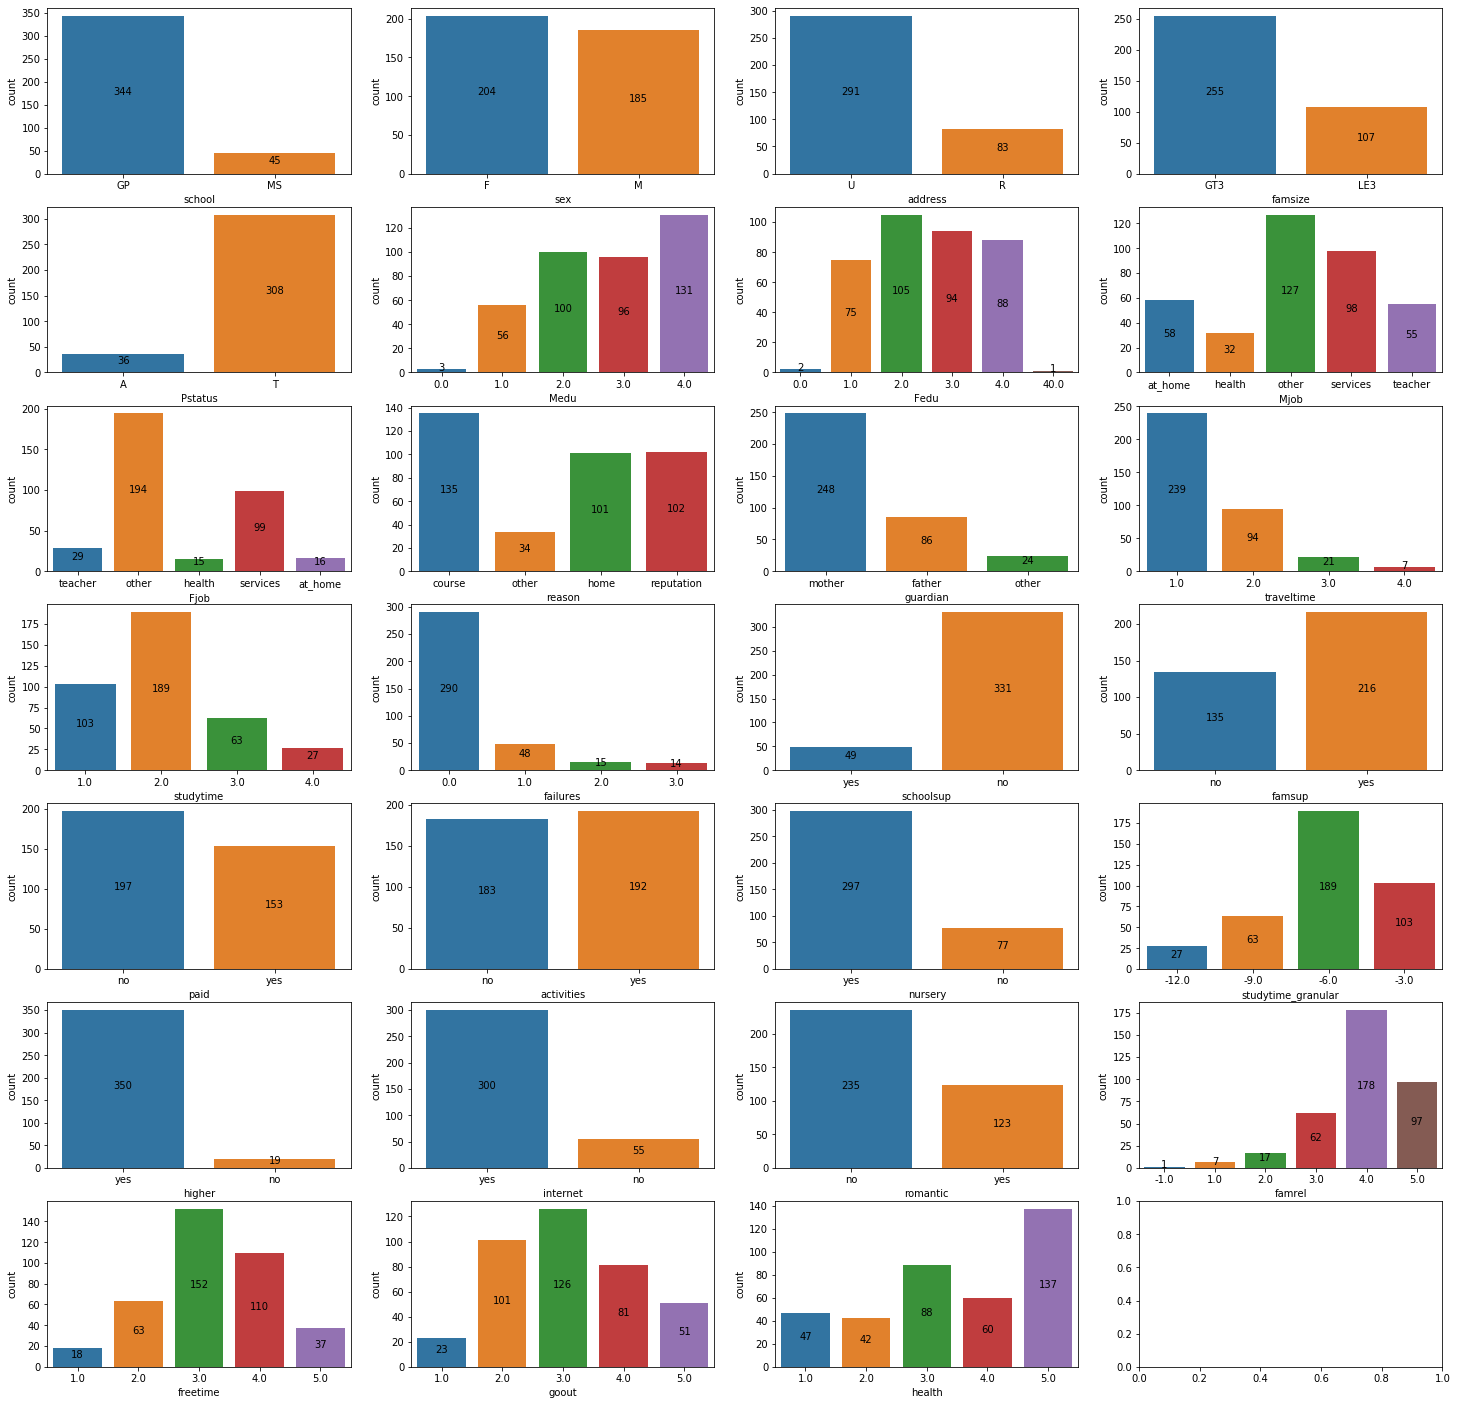

In [623]:
mass_visualize_grid('cat', cols_categorical, 4, df_students)

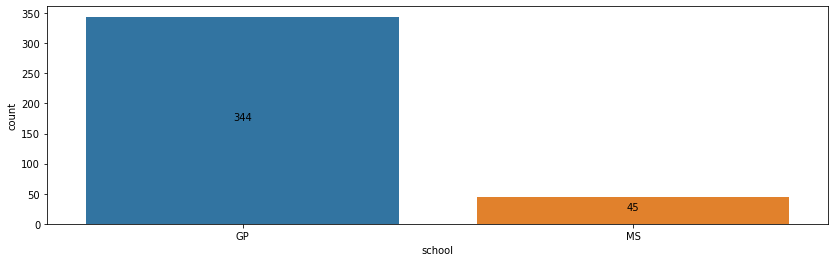

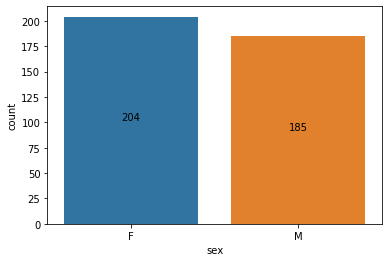

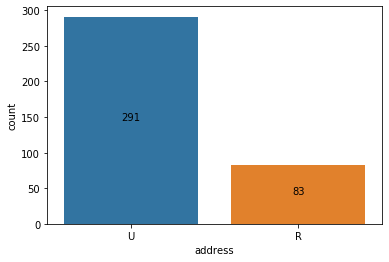

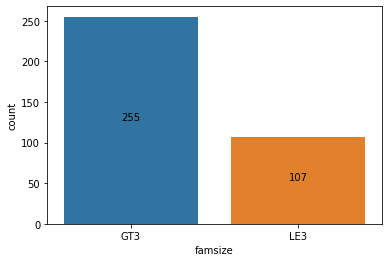

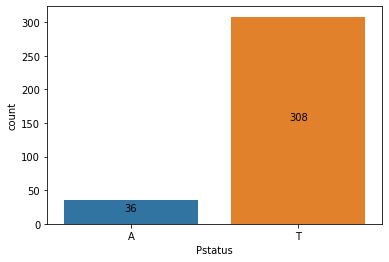

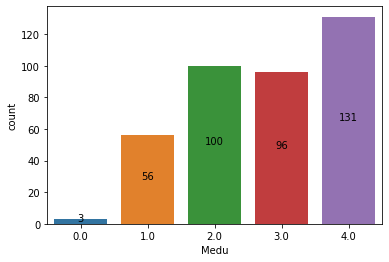

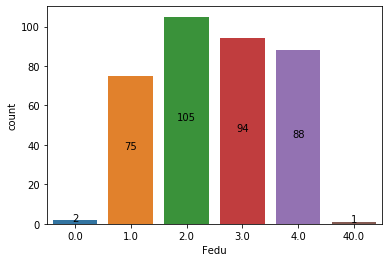

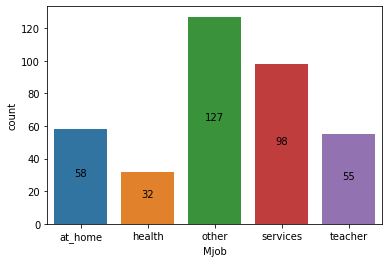

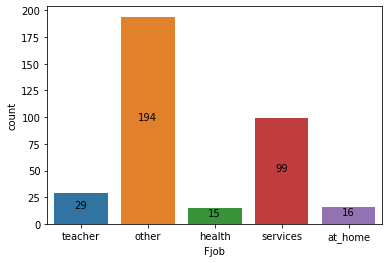

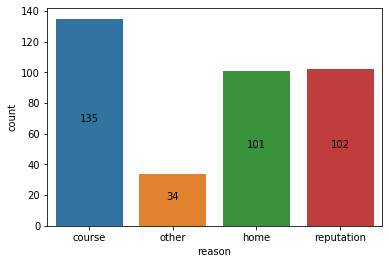

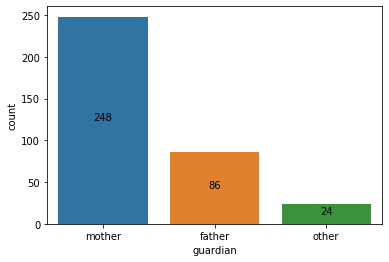

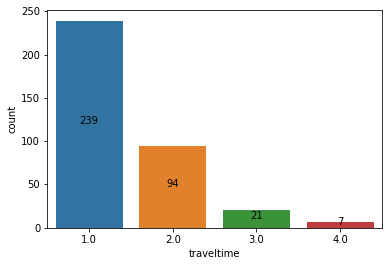

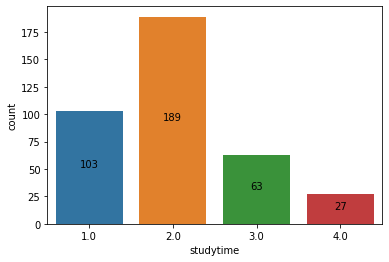

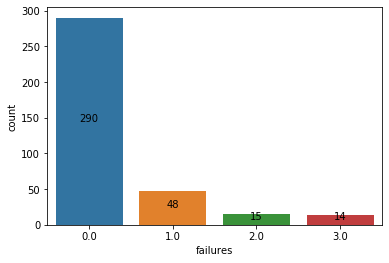

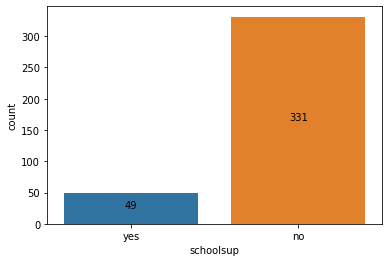

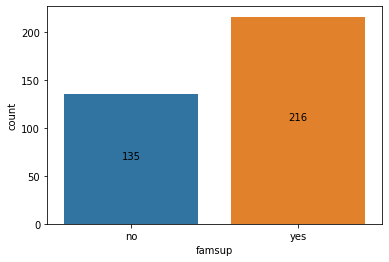

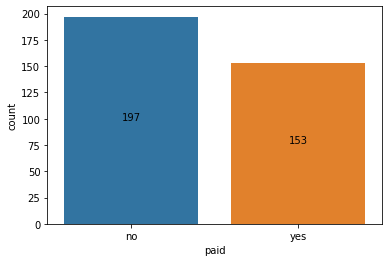

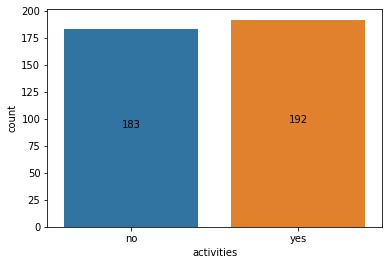

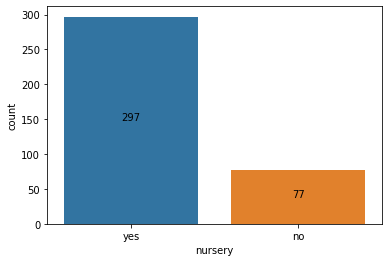

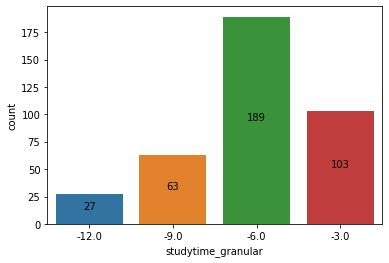

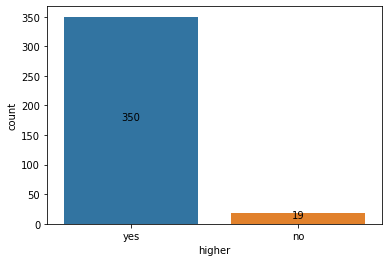

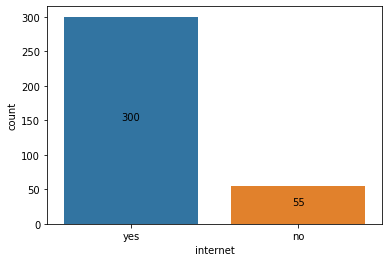

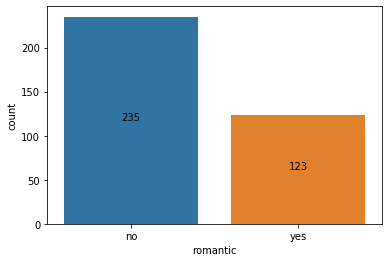

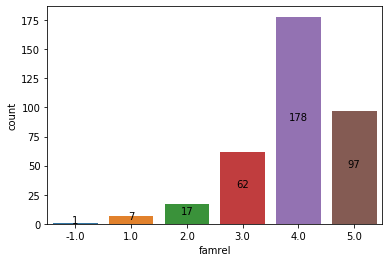

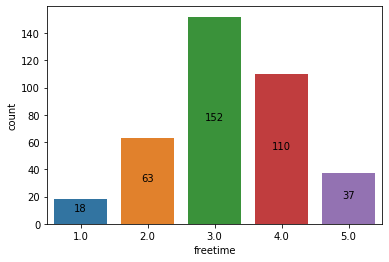

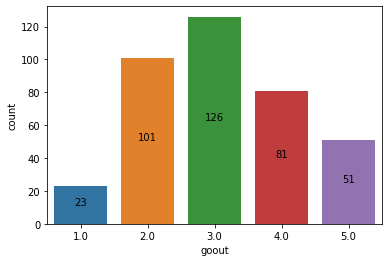

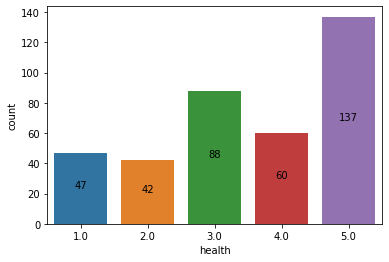

In [624]:
# creating line by line visualization to see the values better
mass_visualize_line('cat', cols_categorical, df_students)

# Preliminary notes after the inspection of countplots for categorical variables
1) It seems that there are only 2 schools present in this list (GP and MS). And most data comes from GP. If it is really an abbreviation of a school name then this data set might not be representative for other schools. Need to try and find out what that really is.

2) Fedu (mother's education) has some values that seem to be incorrectly entered (40). I think they should simply be changed to higher education (4).

3) Column failures doesn't make much sense to me because it seems that 0 might mean both that there are no failures and that there are more than 3 failures (at least based on a column definition). Need to check it further, but it looks like this column is a good candidate for deletion.

4) Column "studytime_granular" is not mentioned in a dataset description at all. By the looks of data I can't really decide what it means. However, this column won't be deleted right away. It needs to be further analyzed. Maybe it's a good predictor of some sort. In this case it can be kept, but the meaning of it should be clarified.

5) There are values -1 in column famrel. It contradicts the description of that column. I believe, that -1 should be changed to 1 because it might be a typo.

6) Missing values can be replaced with actual values based on their frequency distribution (column freq_dict in a dataframe df_description).

In [625]:
df_students.loc[df_students[df_students['Fedu'] > 4].index[0], 'Fedu'] = 4

In [626]:
df_students.loc[df_students[df_students['famrel']  == -1].index[0], 'famrel'] = 1

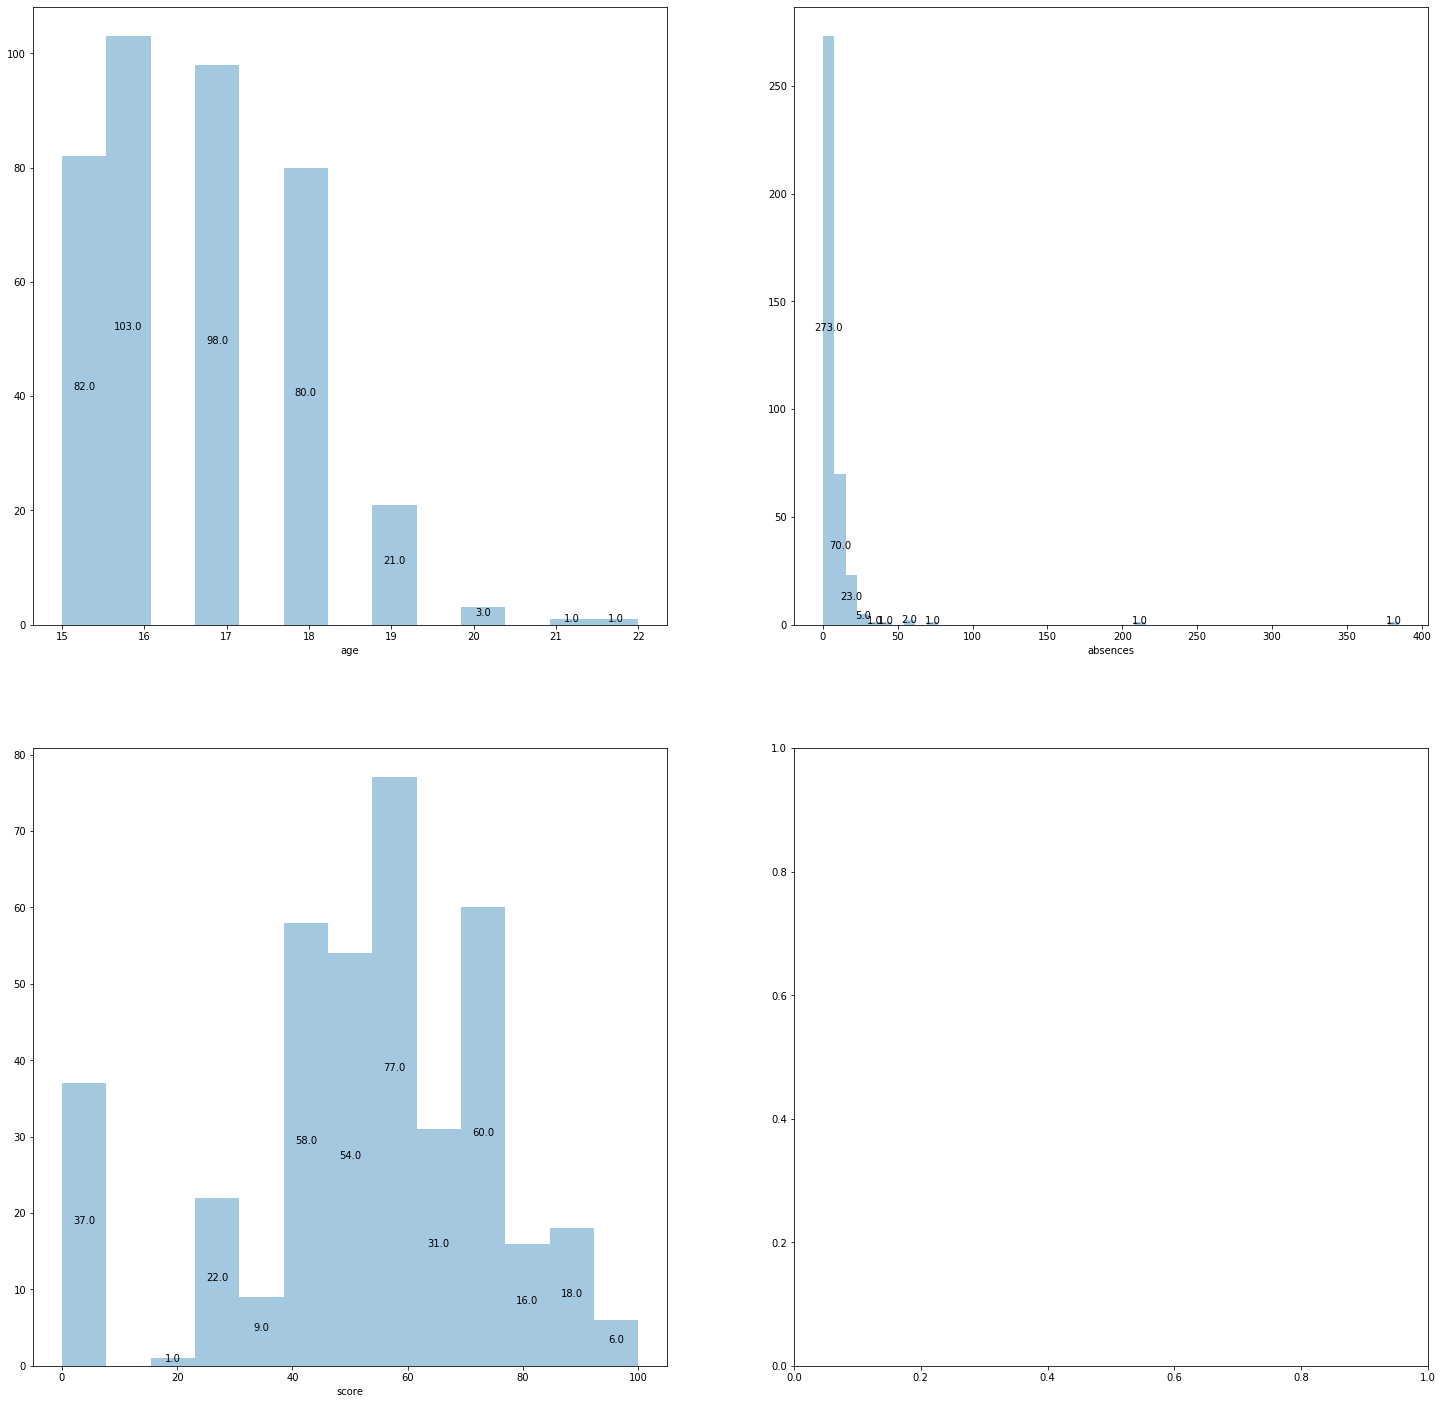

In [627]:
mass_visualize_grid('num', cols_numeric, 2, df_students)

In [628]:
df_students['score'].value_counts().sort_index()

0.0      37
20.0      1
25.0      7
30.0     15
35.0      9
40.0     31
45.0     27
50.0     54
55.0     46
60.0     31
65.0     31
70.0     27
75.0     33
80.0     16
85.0      6
90.0     12
95.0      5
100.0     1
Name: score, dtype: int64

In [629]:
df_students['absences'].value_counts().sort_index()

0.0      110
1.0        3
2.0       60
3.0        7
4.0       52
5.0        5
6.0       30
7.0        6
8.0       20
9.0        3
10.0      17
11.0       2
12.0      12
13.0       2
14.0      12
15.0       2
16.0       7
17.0       1
18.0       5
19.0       1
20.0       4
21.0       1
22.0       3
23.0       1
24.0       1
25.0       1
26.0       1
28.0       1
30.0       1
38.0       1
40.0       1
54.0       1
56.0       1
75.0       1
212.0      1
385.0      1
Name: absences, dtype: int64